In [1]:
import sys
path = ".."
if path not in sys.path:
    sys.path.append(path)

In [2]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.transform import Rotation
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go

In [3]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

def calculate_position_errors(predicted_trajectory, truth_trajectory, show_statistic=True):
    position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
    if show_statistic:
        print("Mean position error: {}".format(np.mean(position_errors)))
        print("Median position error: {}".format(np.median(position_errors)))
    return position_errors

def invert_positions(positions):
    result = np.zeros_like(positions)
    result[:, :3, :3] = np.transpose(positions[:, :3, :3], (0, 2, 1))
    result[:, :3, 3] = -np.einsum('ijk, ik->ij', result[:, :3, :3], positions[:, :3, 3])
    result[:, 3, 3] = 1
    return result

def get_quaternion(positions):
    rotations = Rotation.from_matrix(positions[:, :3, :3])
    return rotations.as_quat()

def calculate_rotation_errors(predicted_rotation, truth_rotation, show_statistic=True):
    rotation_errors = [quaternion_angular_error(q1, q2) for q1, q2 in zip(truth_rotation, predicted_rotation)]
    rotation_errors = np.array(rotation_errors)
    if show_statistic:
        print("Mean rotation error: {}".format(np.mean(rotation_errors)))
        print("Median rotation error: {}".format(np.median(rotation_errors)))
    return rotation_errors

In [4]:
def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.show()

# Load model

In [5]:
from lieposenet.data.seven_scenes import SevenScenes
from lieposenet.utils import TensorBoardLogger, load_hparams_from_yaml
from lieposenet import ModelFactory

In [6]:
# resnet = models.resnet34(pretrained=True)
# resnet_parts = list(resnet.children())
# model = nn.Sequential(*resnet_parts[:-1]).cuda()
# model.eval();

In [9]:
params = load_hparams_from_yaml("../configs/pose_net.yaml")
# Make model
model = ModelFactory().make_model(params.model, data_saver_path=".")

# Load model
model.load_state_dict(torch.load("../models/chess_pose_net.pth.ckpt")['state_dict'])
model = model.feature_extractor.cuda()
model.eval();

In [10]:
def get_sequence_data(scene, sequence):
    image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
    dataset = SevenScenes(scene, "../data/7scenes", True, image_transform, mode=0, seed=0, sequences=[sequence])
    data_loader = torch.utils.data.DataLoader(dataset, 32, False, pin_memory=True, num_workers=4)
    features = np.zeros([0, 2048])
    positions = np.zeros([0, 4, 4])
    for batch in data_loader:
        result = model(batch["image"].cuda())[:, :].cpu().detach().numpy()
        features = np.concatenate([features, result], axis=0)
        positions = np.concatenate([positions, batch["position"]], axis=0)
    return features, positions

def load_sequences_data(scene, sequences):
    features = []
    positions = []
    for sequence in sequences:
        feature, position = get_sequence_data(scene, sequence)
        features.append(feature)
        positions.append(position)
    return features, positions

In [11]:
def get_variances(reg, x):
    sigma = reg.sigma_
    x1 = x @ reg.sigma_
    return np.sum(x * x1, axis=1) + 1 / reg.alpha_

In [12]:
features, positions = load_sequences_data("fire", [1, 2, 3, 4])

# Graphics

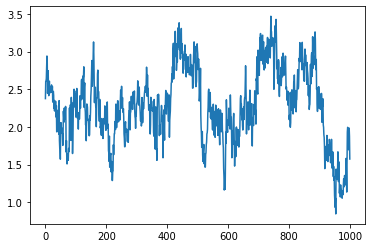

In [42]:
# plt.plot(positions[0][:1000, , 3])
plt.plot(features[0][:1000, 0])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



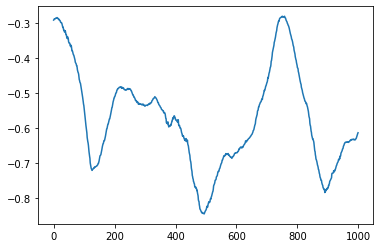

In [22]:
sns.lineplot(range(1000), positions[0][:1000, 1, 3])

In [106]:
from sklearn.mixture import BayesianGaussianMixture
from gmr import GMM
from sklearn.decomposition import PCA

0.9296232947875399


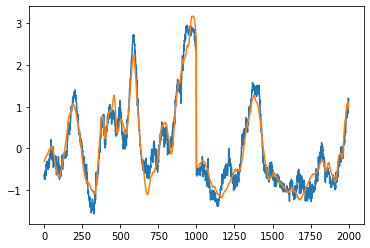

In [400]:
n_component = 0
f = np.concatenate(features[:2], axis=0)
# f = np.tanh(f)
pca = PCA(n_components=n_component + 1, whiten=True).fit(f)
f = pca.transform(f)
# f = np.tanh(f)
p = np.concatenate(positions[:2], axis=0)
q = Rotation.from_matrix(p[:, :3, :3]).as_rotvec()
p = np.concatenate([p[:, :3, 3], q], axis=1)
p = np.concatenate([p, p ** 2, p**3], axis=1)
data = np.concatenate([p, f[:, :]], axis=1)
reg = BayesianRidge().fit(p, f[:, n_component])
# reg = GMM(n_components=4).from_samples(data)
# print(reg.score(p, f[:, 0]))
# f1 = reg.predict(list(range(6)), p)
f1 = reg.predict(p)[:, None]
print(reg.score(p, f[:, n_component]))
plt.plot(f[:, n_component])
plt.plot(f1[:, 0])

-1.0050281171565176


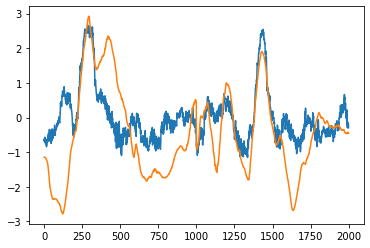

In [401]:
f = np.concatenate(features[2:], axis=0)
# f = np.tanh(f)
f = pca.transform(f)
# f = np.tanh(f)
p = np.concatenate(positions[2:], axis=0)
q = Rotation.from_matrix(p[:, :3, :3]).as_rotvec()
p = np.concatenate([p[:, :3, 3], q], axis=1)
p = np.concatenate([p, p ** 2, p ** 3], axis=1)
# print(reg.score(p, f[:, 0]))
# f1 = reg.predict(list(range(6)), p)
print(reg.score(p, f[:, n_component]))
f1 = reg.predict(p)[:, None]
plt.plot(f[:, n_component])
plt.plot(f1[:, 0])

# Position regression

In [336]:
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression

In [337]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[:2], axis=0)
regx = BayesianRidge().fit(f, p[:, 0, 3])
# print(1 / regx.alpha_ ** 0.5)
print(regx.score(f, p[:, 0, 3]))
regy = BayesianRidge().fit(f, p[:, 1, 3])
print(regy.score(f, p[:, 1, 3]))
regz = BayesianRidge().fit(f, p[:, 2, 3])
print(regz.score(f, p[:, 2, 3]))

0.998989813373298
0.9977644965375517
0.9979967495437538


In [338]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[2:], axis=0)
x = regx.predict(f)
print(regx.score(f, p[:, 0, 3]))
y = regy.predict(f)
print(regy.score(f, p[:, 1, 3]))
z = regz.predict(f)
print(regz.score(f, p[:, 2, 3]))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]

varx = get_variances(regx, f)
vary = get_variances(regy, f)
varz = get_variances(regz, f)

0.7455307366423629
0.6049300505328571
0.5488541830099665


In [339]:
position_errors_linear = calculate_position_errors(predicted_trajectory, truth_trajectory)

Mean position error: 0.36502126842599764
Median position error: 0.31598351795353075


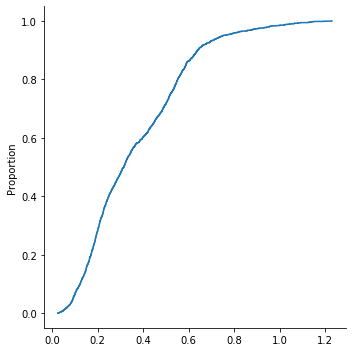

In [340]:
sns.displot(position_errors_linear, kind="ecdf")

In [341]:
deltas = predicted_trajectory - truth_trajectory
print(np.mean(deltas, axis=0))
for i in range(1, 3):
    print(scipy.stats.moment(deltas, i + 1, axis=0))

[-0.0050405   0.04782496 -0.10302716]
[0.09337763 0.03293934 0.04276436]
[-0.01741947  0.00555027 -0.00607378]


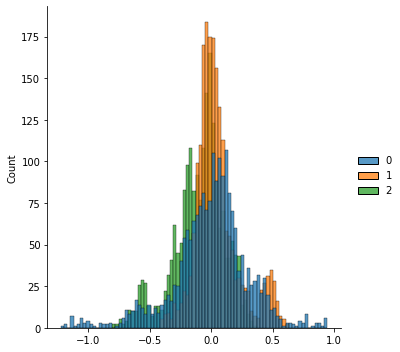

In [342]:
sns.displot(deltas)

### Rotation

In [343]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[:2], axis=0)
rotations = Rotation.from_matrix(p[:, :3, :3])
# q = rotations.as_rotvec()
q = rotations.as_quat()
regqx = BayesianRidge().fit(f, q[:, 0])
print(regqx.score(f, q[:, 0]))
regqy = BayesianRidge().fit(f, q[:, 1])
print(regqy.score(f, q[:, 1]))
regqz = BayesianRidge().fit(f, q[:, 2])
print(regqz.score(f, q[:, 2]))
regqw = BayesianRidge().fit(f, q[:, 3])
print(regqw.score(f, q[:, 3]))

0.9971089870532881
0.9990496162263085
0.998825477145696
0.9988633107910371


In [344]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[2:], axis=0)
rotations = Rotation.from_matrix(p[:, :3, :3])
# q = rotations.as_rotvec()
q = rotations.as_quat()
qx = regqx.predict(f)
print(regqx.score(f, q[:, 0]))
qy = regqy.predict(f)
print(regqy.score(f, q[:, 1]))
qz = regqz.predict(f)
print(regqz.score(f, q[:, 2]))
qw = regqw.predict(f)
print(regqz.score(f, q[:, 3]))
predicted_rotations = np.array([qx, qy, qz, qw]).T
# predicted_rotations = np.array([qx, qy, qz]).T
# predicted_rotations = predicted_rotations / np.linalg.norm(predicted_rotations, axis=1)[:, None]
# predicted_rotations = Rotation.from_rotvec(predicted_rotations)
predicted_rotations = Rotation.from_quat(predicted_rotations)
predicted_rotations = predicted_rotations.as_quat()
truth_rotations = rotations.as_quat()


varqx = get_variances(regqx, f)
varqy = get_variances(regqy, f)
varqz = get_variances(regqz, f)

0.33025724571940185
0.46706650457005916
0.4062849852669961
-9.886298745377326


In [345]:
rotations_erros = calculate_rotation_errors(predicted_rotations, truth_rotations)

Mean rotation error: 20.221089090352
Median rotation error: 14.09455701787381


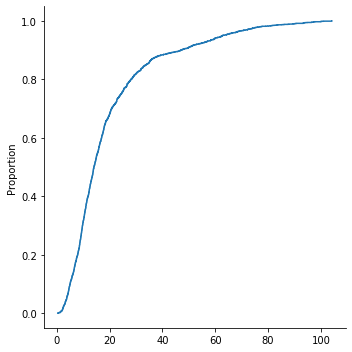

In [346]:
sns.displot(rotations_erros, kind="ecdf")

## PLS

In [347]:
from sklearn.cross_decomposition import PLSRegression

In [370]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
# f = np.concatenate([f, f ** 2], axis=1)
p = np.concatenate(positions[:2], axis=0)
reg_pls = PLSRegression(n_components=32).fit(f, p[:, :3, 3])
reg_pls.score(f, p[:, :3, 3])
reg_pls_trajectory = reg_pls

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



In [371]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
# f = np.concatenate([f, f ** 2], axis=1)
p = np.concatenate(positions[2:], axis=0)
predicted_positions = reg_pls.predict(f)
predicted_trajectory = predicted_positions
truth_trajectory = p[:, :3, 3]

In [372]:
position_errors_pls = calculate_position_errors(predicted_trajectory, truth_trajectory)

Mean position error: 0.356079361362327
Median position error: 0.30237028615326


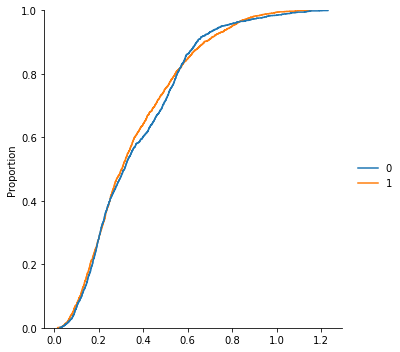

In [351]:
sns.displot([position_errors_linear, position_errors_pls], kind="ecdf")

[ 0.00355501  0.04251819 -0.10206002]


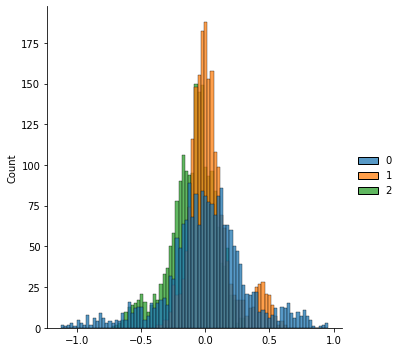

In [352]:
sns.displot(predicted_trajectory - truth_trajectory)
print(np.mean(predicted_trajectory - truth_trajectory, axis=0))

In [353]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
# f = np.concatenate([f], axis=1)
p = np.concatenate(positions[:2], axis=0)
rotations = Rotation.from_matrix(p[:, :3, :3])
q = rotations.as_quat()
reg_pls = PLSRegression(n_components=16).fit(f, q)
reg_pls.score(f, q)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



0.984980051421434

In [354]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
# f = np.concatenate([f, f ** 2], axis=1)
p = np.concatenate(positions[2:], axis=0)
rotations = Rotation.from_matrix(p[:, :3, :3])
q = rotations.as_quat()

predicted_rotations = reg_pls.predict(f)
print(reg_pls.score(f, q))

predicted_rotations = Rotation.from_quat(predicted_rotations).as_quat()
truth_rotations = Rotation.from_quat(q).as_quat()

0.30768088047778025


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



In [355]:
rotations_erros = calculate_rotation_errors(predicted_rotations, truth_rotations)

Mean rotation error: 19.712043949595042
Median rotation error: 13.30038195833988


In [363]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[:2], axis=0)
rotations = Rotation.from_matrix(p[:, :3, :3])
p = np.concatenate([p[:, :3, 3], rotations.as_quat()], axis=1)
reg_pls = PLSRegression(n_components=32).fit(f, p)
reg_pls.score(f, p)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



0.9898462789908684

In [364]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[2:], axis=0)
rotations = Rotation.from_matrix(p[:, :3, :3])
p = np.concatenate([p[:, :3, 3], rotations.as_quat()], axis=1)
print(reg_pls.score(f, p))
predicted_positions = reg_pls.predict(f)
predicted_trajectory = predicted_positions[:, :3]
truth_trajectory = p[:, :3]
predicted_rotations = Rotation.from_quat(predicted_positions[:, 3:]).as_quat()
truth_rotations = rotations.as_quat()

0.5862454125849288


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



In [365]:
position_errors_pls = calculate_position_errors(predicted_trajectory, truth_trajectory)
rotations_erros = calculate_rotation_errors(predicted_rotations, truth_rotations)

Mean position error: 0.3579043604930725
Median position error: 0.298360094131474
Mean rotation error: 19.72024906095114
Median rotation error: 12.677162907088388


# PCA

In [249]:
from sklearn.decomposition import PCA

In [250]:
# f = np.concatenate(features[2:], axis=0)
f = np.concatenate(features[:2], axis=0)
pca = PCA(n_components=32).fit(f)
f = pca.transform(f)
p = np.concatenate(positions[:2], axis=0)
regx = BayesianRidge().fit(f, p[:, 0, 3])
x1 = regx.predict(f)
print(regx.score(f, p[:, 0, 3]))
regy = BayesianRidge().fit(f, p[:, 1, 3])
y1 = regy.predict(f)
print(regy.score(f, p[:, 1, 3]))
regz = BayesianRidge().fit(f, p[:, 2, 3])
z1 = regz.predict(f)
print(regz.score(f, p[:, 2, 3]))

0.9565443888967465
0.9379983828072418
0.9369685532085114


In [251]:
f = np.concatenate(features[2:], axis=0)
f = pca.transform(f)
p = np.concatenate(positions[2:], axis=0)
x = regx.predict(f)
print(regx.score(f, p[:, 0, 3]))
y = regy.predict(f)
print(regy.score(f, p[:, 1, 3]))
z = regz.predict(f)
print(regz.score(f, p[:, 2, 3]))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]
x2, y2, z2 = x, y, z

0.6691366762514324
0.638640872460972
0.6451430041663248


In [252]:
position_errors_pca = calculate_position_errors(predicted_trajectory, truth_trajectory)

Mean position error: 0.38335856055787376
Median position error: 0.3408716680437186


In [253]:
sns.displot([position_errors_linear, position_errors_pls, position_errors_pca], kind="ecdf")

NameError: name 'position_errors_linear' is not defined

In [254]:
deltas = predicted_trajectory - truth_trajectory
print(np.mean(deltas, axis=0))
for i in range(1, 3):
    print(scipy.stats.moment(deltas, i + 1, axis=0))

[-0.01659595  0.04679879 -0.08368165]
[0.12116808 0.0300306  0.03498357]
[-0.01660718  0.00515028 -0.00064089]


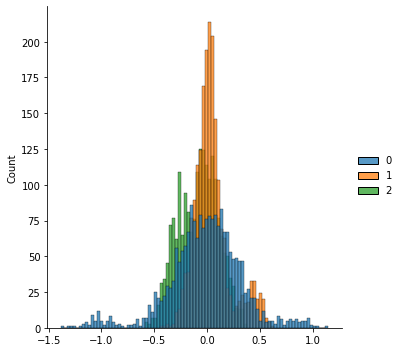

In [255]:
sns.displot(predicted_trajectory - truth_trajectory)

In [258]:
f = np.concatenate(features[:2], axis=0)
pca = PCA(n_components=6).fit(f)
f = f - pca.inverse_transform(pca.transform(f))
p = np.concatenate(positions[:2], axis=0)
regx = BayesianRidge().fit(f, p[:, 0, 3] - x1)
print(regx.score(f, p[:, 0, 3] - x1))
regy = BayesianRidge().fit(f, p[:, 1, 3] - y1)
print(regy.score(f, p[:, 1, 3] - y1))
regz = BayesianRidge().fit(f, p[:, 2, 3] - z1)
print(regz.score(f, p[:, 2, 3] - z1))

0.8953725817983315
0.8500417734515536
0.8467580669013972


In [259]:
f = np.concatenate(features[2:], axis=0)
f = f - pca.inverse_transform(pca.transform(f))
# f = np.concatenate([f, f ** 2], axis=1)
# f = np.concatenate([f, 1 / f], axis=1)
p = np.concatenate(positions[2:], axis=0)
x = regx.predict(f) + x2
print(regx.score(f, p[:, 0, 3]))
y = regy.predict(f) + y2
print(regy.score(f, p[:, 1, 3]))
z = regz.predict(f) + z2
print(regz.score(f, p[:, 2, 3]))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]

-0.20569935001994447
-2.689164423965336
-5.865192094103547


In [260]:
position_errors_pca = calculate_position_errors(predicted_trajectory, truth_trajectory)

Mean position error: 0.3585091321392971
Median position error: 0.29794734693486996


In [68]:
f = np.concatenate(features[:2], axis=0)
p = np.concatenate(positions[:2], axis=0)
pca = PCA(n_components=6 * 5).fit(f)
f = pca.transform(f)
x1, y1, z1 = 0, 0, 0
regs = []
for i in range(5):
    f1 = f[:, i * 6:i * 6 + 6]
    
    regx = BayesianRidge().fit(f1, p[:, 0, 3] - x1)
    print(regx.score(f1, p[:, 0, 3] - x1))
    x1 = x1 + regx.predict(f1)
    regy = BayesianRidge().fit(f1, p[:, 1, 3] - y1)
    print(regy.score(f1, p[:, 1, 3] - y1))
    y1 = y1 + regy.predict(f1)
    regz = BayesianRidge().fit(f1, p[:, 2, 3] - z1)
    print(regz.score(f1, p[:, 2, 3] - z1))
    z1 = z1 + regz.predict(f1)
    regs.append((regx, regy, regz))

0.9527952135159016
0.5179434977268068
0.7119696139436558
0.6616761811581116
0.7338853540221675
0.6717186101791
0.2423603168077033
0.30074218616003956
0.4236687881185397
0.275971150397905
0.3456342311921332
0.2078526500386254
0.10200900688229586
0.22645135122560156
0.3544073824424466


In [77]:
f = np.concatenate(features[2:], axis=0)
# f = f - pca.inverse_transform(pca.transform(f))
f = pca.transform(f)
p = np.concatenate(positions[2:], axis=0)
x2, y2, z2 = 0, 0, 0

for i in range(5):
    f1 = f[:, i * 6:i * 6 + 6]
    regx, regy, regz = regs[i]
    x2 = regx.predict(f1) + x2
    print(regx.score(f1, p[:, 0, 3]))
    y2 = regy.predict(f1) + y2
    print(regy.score(f1, p[:, 1, 3]))
    z2 = regz.predict(f1) + z2
    print(regz.score(f1, p[:, 2, 3]))
predicted_trajectory = np.array([x2, y2, z2]).T
truth_trajectory = p[:, :3, 3]

0.7837581331272389
-0.09457983112478674
0.13424499045133842
0.10926966888196676
-1.4467685286511198
-5.756734569377896
0.01233857031751817
-2.685150173826503
-5.573991129757951
-0.05800435610504717
-2.5181494536369757
-5.785051779198238
-0.014878000146115289
-2.6140347363371235
-5.733623043622457


In [78]:
position_errors_pca = calculate_position_errors(predicted_trajectory, truth_trajectory)

Mean position error: 0.35935513118098844
Median position error: 0.32946638694306674


# GMM

In [387]:
import numpy.random

In [391]:
np.random.seed(0)
n_components = 12
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
pca = PCA(n_components=n_components, whiten=False).fit(f)
f = reg_pls_trajectory.transform(f)

p = np.concatenate(positions[:2], axis=0)
q = Rotation.from_matrix(p[:, :3, :3]).as_rotvec()
p = np.concatenate([p[:, :3, 3], q], axis=1)

data = np.concatenate([p, f], axis=1)
reg = GMM(n_components=4).from_samples(data)

In [392]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
f = reg_pls_trajectory.transform(f)

p = np.concatenate(positions[2:], axis=0)
# q = Rotation.from_matrix(p[:, :3, :3]).as_rotvec()
# p = np.concatenate([p[:, :3, 3], q], axis=1)

predict = reg.predict(list(range(6, 6 + 32)), f)
predicted_trajectory = predict[:, :3]
truth_trajectory = p[:, :3, 3]

predicted_rotations = Rotation.from_rotvec(predict[:, 3:6]).as_quat()
truth_rotations = Rotation.from_matrix(p[:, :3, :3]).as_quat()

In [393]:
position_errors_pca = calculate_position_errors(predicted_trajectory, truth_trajectory)
rotations_erros = calculate_rotation_errors(predicted_rotations, truth_rotations)

Mean position error: 0.34927546964288264
Median position error: 0.2971220563221395
Mean rotation error: 21.537548909989905
Median rotation error: 14.007647237498556


# Pose graph optimization

In [117]:
from minisam import *

In [119]:
data = np.loadtxt("/home/mikhail/research/geomapnet/data/7Scenes/fire/dso_poses/seq-03.txt")
odometry_indexes = data[:, 0].astype(np.int)
odometry_positions = np.zeros((data.shape[0], 4, 4))
odometry_positions[:, :3, :] = data[:, 1:].reshape(-1, 3, 4)
odometry_positions[:, 3, 3] = 1.

In [120]:
def get_positions(translations, rotations):
    positions = np.zeros([len(translations), 4, 4])
    positions[:, :3, 3] = translations
    positions[:, :3, :3] = Rotation.from_quat(rotations).as_matrix()
    positions[:, 3, 3] = 1
    return positions

In [121]:
graph = FactorGraph()
initials = Variables()
prior_loss = ScaleLoss.Scale(2) 
ps = get_positions(predicted_trajectory, predicted_rotations)[:1000]
for i, (position) in enumerate(ps):
    u, d, v = np.linalg.svd(position[:3, :3])
    position[:3, :3] = u @ v
    prior_loss = DiagonalLoss.Variances([varx[i], vary[i], varz[i], varqx[i], varqy[i], varqz[i]])
    graph.add(PriorFactor(key('x', i), SE3(position), prior_loss))
    initials.add(key('x', i), SE3(position))

linear_sigma = 0.02
angular_sigma = 0.02
odometry_loss = DiagonalLoss.Sigmas(np.array([linear_sigma, linear_sigma, linear_sigma, 
                                              angular_sigma, angular_sigma, angular_sigma]))
for i in range(len(odometry_positions) - 1):
    odometry_delta = odometry_positions[i + 1] @ np.linalg.inv(odometry_positions[i])
    u, d, v = np.linalg.svd(odometry_delta[:3, :3])
    odometry_delta[:3, :3] = u @ v
    graph.add(BetweenFactor(key('x', int(odometry_indexes[i])), key('x', int(odometry_indexes[i + 1])), 
                            SE3(odometry_delta), odometry_loss))

In [122]:
optimizer_param = LevenbergMarquardtOptimizerParams()
optimizer = LevenbergMarquardtOptimizer(optimizer_param)

results = Variables()
status = optimizer.optimize(graph, initials, results)
if status != NonlinearOptimizationStatus.SUCCESS:
    print("optimization error: ", status)

In [123]:
optimized_trajectory = [results.at(key("x", i)).translation() for i in range(len(ps))]
optimized_trajectory = np.array(optimized_trajectory)

In [124]:
calculate_position_errors(truth_trajectory[:1000], optimized_trajectory[:1000]);

Mean position error: 0.4071589434469034
Median position error: 0.41260767214612915


In [126]:
calculate_position_errors(truth_trajectory[:1000], predicted_trajectory[:1000]);

Mean position error: 0.4129842550232039
Median position error: 0.41653877108642934


In [127]:
calculate_position_errors(truth_trajectory, predicted_trajectory);

Mean position error: 0.3271016880729304
Median position error: 0.2875705684708579


In [129]:
show_trajectories(truth_trajectory[:1000], optimized_trajectory[:1000])

In [130]:
show_trajectories(truth_trajectory[:1000], predicted_trajectory[:1000])

# Virtural key points

In [342]:
def norm_angles(angles):
    return (angles + np.pi) % (2 * np.pi) - np.pi

def rmse(x):
    return np.sqrt(np.mean(x ** 2))

def error3d(vec1, vec2):
    return np.arccos(np.sum(vec1 * vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2))

In [349]:
def calculate_keypoint(positions, global_point):
    inv_posistions = invert_positions(positions)
    global_point = np.concatenate([global_point, np.array([1])], axis=0)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
    x = transformed_point[:, 0]
    y = transformed_point[:, 1]
    z = transformed_point[:, 2]
    scale = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return x / scale, y / scale, z / scale

In [354]:
global_point = np.array([-1, 2, 3])
p = np.concatenate(positions[2:], axis=0)
predicted_positions = get_positions(predicted_trajectory, predicted_rotations)
pred_x1, pred_y1, pred_z1 = calculate_keypoint(predicted_positions, global_point)
true_x, true_y, true_z = calculate_keypoint(p, global_point)
print("error x ", rmse(norm_angles(true_x - pred_x1)) * 180 / np.pi)
print("error y ", rmse(norm_angles(true_y - pred_y1)) * 180 / np.pi)
print("error3d ", error3d(np.array([pred_x1, pred_y1, pred_z1 ]), 
                          np.array([true_x, true_y, true_z])) * 180 / np.pi)

error x  6.481723270039415
error y  5.41439791036323
error3d  9.118265948721785


In [355]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[:2], axis=0)
true_x, true_y, true_z = calculate_keypoint(p, global_point)
regpx = BayesianRidge().fit(f, true_x)
print(regpx.score(f, true_x))
regpy = BayesianRidge().fit(f, true_y)
print(regpy.score(f, true_y))
regpz = BayesianRidge().fit(f, true_z)
print(regpy.score(f, true_z))

0.999917914950177
0.9999023036067946
0.9999023036067946


In [360]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[2:], axis=0)
true_x, true_y, true_z = calculate_keypoint(p, global_point)
pred_x = regpx.predict(f)
print(regpx.score(f, true_x))
pred_y = regpy.predict(f)
print(regpy.score(f, true_y))
pred_z = regpz.predict(f)
print(regpy.score(f, true_z))
print("error x ", rmse(norm_angles(true_x - pred_x)) * 180 / np.pi)
print("error y ", rmse(norm_angles(true_y - pred_y)) * 180 / np.pi)
print("error3d ", error3d(np.array([pred_x, pred_y, pred_z]), 
                          np.array([true_x, true_y, true_z])) * 180 / np.pi)

0.7664632037635034
0.7560471038704213
-17.02996503308645
error x  6.775925828520019
error y  5.920814559775563
error3d  9.890959533280391


In [361]:
global_points = np.array([[0, 100, 1.5], [1, 2, 3], [-1, 2, 3], [1, 1, 1]])
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
p = np.concatenate(positions[:2], axis=0)
output1 = np.zeros([2000, 0])
for global_point in global_points:
    true_x, true_y, true_z = calculate_keypoint(p, global_point)
    output1 = np.concatenate([output1, true_x[:, None], true_y[:, None], true_z[:, None]], axis=1)
reg_pls = PLSRegression(n_components=16).fit(f, output1)
reg_pls.score(f, output1)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



0.9872462626936634

In [369]:
f = np.concatenate(features[:2], axis=0)
f = np.tanh(f)
original_f = f
p = np.concatenate(positions[:2], axis=0)
true_x, true_y, true_z = calculate_keypoint(p, global_point)
f = np.concatenate([f * true_x[:, None], f * true_y[:, None], f * true_z[:, None]], axis=1)
pca = PCA(n_components=1).fit(f)
pred_x = pca.transform(np.concatenate([original_f * 1, original_f * 0, original_f * 0], axis=1))[:, 0]
pred_y = pca.transform(np.concatenate([original_f * 0, original_f * 1, original_f * 0], axis=1))[:, 0]
pred_z = pca.transform(np.concatenate([original_f * 0, original_f * 0, original_f * 1], axis=1))[:, 0]
print("error x ", rmse(norm_angles(true_x - pred_x)) * 180 / np.pi)
print("error y ", rmse(norm_angles(true_y - pred_y)) * 180 / np.pi)
print("error3d ", error3d(np.array([pred_x, pred_y, pred_z]), 
                          np.array([true_x, true_y, true_z])) * 180 / np.pi)

error x  100.44772196134046
error y  112.9548582408966
error3d  88.94997811918059


In [370]:
pred_x

array([-19.84377078, -19.93608805, -19.92152534, ..., -17.07916407,
       -17.10125796, -17.16834994])

In [371]:
true_x

array([ 0.70771478,  0.70993735,  0.71122332, ..., -0.12382096,
       -0.13350318, -0.12685214])

In [333]:
f = np.concatenate(features[2:], axis=0)
f = np.tanh(f)
# f = np.concatenate([f, f ** 2], axis=1)
p = np.concatenate(positions[2:], axis=0)
output = np.zeros([2000, 0])
for global_point in global_points:
    true_x, true_y = calculate_keypoint(p, global_point)
    output = np.concatenate([output, true_x[:, None], true_y[:, None]], axis=1)
prediction = reg_pls.predict(f)
print(reg_pls.score(f, output))

0.7253451640936007


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').



In [334]:
np.sqrt(np.mean((output - prediction) ** 2, axis=0)) * 180 / np.pi

array([13.71327865,  7.71014542,  4.43092129,  9.34108216,  7.49310943,
        6.62298662, 19.96621884, 10.54885072])

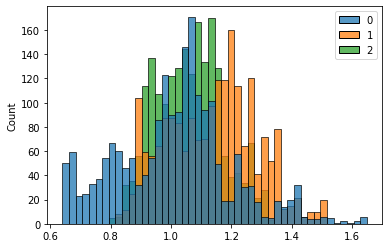

In [335]:
sns.histplot([output[:, 1], output1[:, 1], prediction[:, 1]])